In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import plotly.express as px

# Load dataset
df = pd.read_csv('../Delivery predictions/Train.csv')
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [47]:
df = df.drop(columns=['Gender']) #: DATA CLEANING: Gender column was dropped, no causal relationship to delivery.
df = df.drop(columns=['ID']) 
df = df.dropna()

df.rename(columns={
    'Reached.on.Time_Y.N': 'Reached_on_time',
    'Cost_of_the_Product': 'Product_Cost',
    'Mode_of_Shipment': 'Shipment_mode',
    }, inplace=True)

df.head(20)

,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Product_Cost,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached_on_time
0,D,Flight,4,2,177,3,low,44,1233,1
1,F,Flight,4,5,216,2,low,59,3088,1
2,A,Flight,2,2,183,4,low,48,3374,1
3,B,Flight,3,3,176,4,medium,10,1177,1
4,C,Flight,2,2,184,3,medium,46,2484,1
5,F,Flight,3,1,162,3,medium,12,1417,1
6,D,Flight,3,4,250,3,low,3,2371,1
7,F,Flight,4,1,233,2,low,48,2804,1
8,A,Flight,3,4,150,3,low,11,1861,1
9,B,Flight,3,2,164,3,medium,29,1187,1


In [48]:
# Estimated Delivery Time Arbitrary calculation following assumed logic:

df['Estimated_Delivery_Time'] = (
    df['Weight_in_gms'] / 1000 * 0.5 +            # heavier = longer handling
    df['Discount_offered'] * 0.2 +                # big discounts = more demand = possible delay
    df['Prior_purchases'] * -0.3 +                # loyal customers = faster logistics
    df['Customer_care_calls'] * 1.2               # many calls = friction
)

# Add mode of shipment time offset
mode_time = {'Ship': 12, 'Road': 6, 'Flight': 2}
df['Estimated_Delivery_Time'] += df['Shipment_mode'].map(mode_time)

# -- Simulated Distance (km)
block_distance = {'A': 150, 'B': 300, 'C': 500, 'D': 700, 'F': 1000}          # No "E" value inbetween D & F. We'll imagine E warehouse is currently not in operation.
df['BaseDistance'] = df['Warehouse_block'].map(block_distance)

mode_multiplier = {'Ship': 1.8, 'Road': 1.0, 'Flight': 0.6}
df['Simulated_Distance_km'] = df['BaseDistance'] * df['Shipment_mode'].map(mode_multiplier)


# Relabeling Delivery Status for better interpretation
df['DeliveryStatus'] = df['Reached_on_time'].map({0: 'On Time', 1: 'Late'})
df.head()



,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Product_Cost,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached_on_time,Estimated_Delivery_Time,BaseDistance,Simulated_Distance_km,DeliveryStatus
0,D,Flight,4,2,177,3,low,44,1233,1,15.3165,700,420.0,Late
1,F,Flight,4,5,216,2,low,59,3088,1,19.5440,1000,600.0,Late
2,A,Flight,2,2,183,4,low,48,3374,1,14.4870,150,90.0,Late
3,B,Flight,3,3,176,4,medium,10,1177,1,6.9885,300,180.0,Late
4,C,Flight,2,2,184,3,medium,46,2484,1,13.9420,500,300.0,Late


In [49]:
df[df['DeliveryStatus'] == 'On Time']
#df[df['DeliveryStatus'] == 'Late']         For data exploration purposes


,Warehouse_block,Shipment_mode,Customer_care_calls,Customer_rating,Product_Cost,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached_on_time,Estimated_Delivery_Time,BaseDistance,Simulated_Distance_km,DeliveryStatus
3135,B,Road,6,5,141,3,medium,8,5031,0,16.4155,300,300.0,On Time
3136,C,Road,3,3,219,3,low,4,5956,0,12.4780,500,500.0,On Time
3137,F,Road,4,3,161,3,high,7,4245,0,13.4225,1000,1000.0,On Time
3138,D,Road,4,5,225,4,medium,5,4622,0,12.9110,700,700.0,On Time
3140,A,Road,3,3,256,4,medium,3,4732,0,11.3660,150,150.0,On Time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10993,F,Ship,5,1,257,6,low,1,1150,0,16.9750,1000,1800.0,On Time
10995,B,Ship,4,1,232,5,medium,6,1247,0,17.1235,300,540.0,On Time
10996,C,Ship,5,4,242,5,low,4,1155,0,17.8775,500,900.0,On Time
10997,F,Ship,5,2,223,6,medium,2,1210,0,17.2050,1000,1800.0,On Time


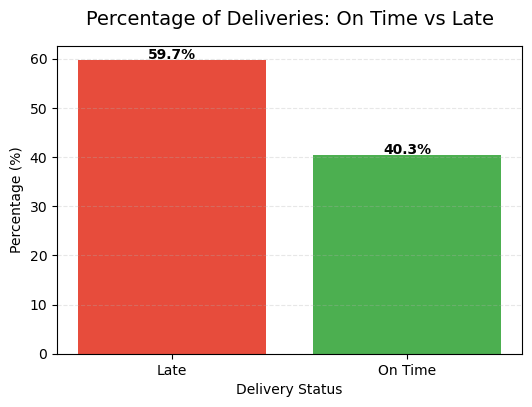

In [50]:
status_counts = df['DeliveryStatus'].value_counts(normalize=True) * 100

plt.figure(figsize=(6,4))
plt.bar(status_counts.index, status_counts.values, color=['#E74C3C', '#4CAF50'])
plt.title('Percentage of Deliveries: On Time vs Late', fontsize=14, pad=15)
plt.xlabel('Delivery Status')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels
for i, v in enumerate(status_counts.values):
    plt.text(i, v + 0.4, f'{v:.1f}%', ha='center', fontweight='bold')   

plt.show()

In [51]:
# Encode Categorical Variables
# Categorical columns: Product_importance, Shipment_mode, Warehouse_block
categorical_cols = ['Warehouse_block', 'Shipment_mode', 'Product_importance'] 
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.columns


Index(['Customer_care_calls', 'Customer_rating', 'Product_Cost',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms',
       'Reached_on_time', 'Estimated_Delivery_Time', 'BaseDistance',
       'Simulated_Distance_km', 'DeliveryStatus', 'Warehouse_block_B',
       'Warehouse_block_C', 'Warehouse_block_D', 'Warehouse_block_F',
       'Shipment_mode_Road', 'Shipment_mode_Ship', 'Product_importance_low',
       'Product_importance_medium'],
      dtype='object')

In [52]:
# Define Features (X) and Target (y)

target = 'Reached_on_time'

features = [
    'Customer_care_calls',
    'Customer_rating',
    'Product_Cost',
    'Prior_purchases',
    'Discount_offered',
    'Weight_in_gms',
    'Estimated_Delivery_Time',
    'Simulated_Distance_km'
] + [col for col in df.columns if any(c in col for c in ['Warehouse_block_', 'Shipment_mode_', 'Product_importance_'])]

X = df[features]
y = df[target]

print("Final feature set:", X.shape)
X.head()

Final feature set: (10999, 16)


,Customer_care_calls,Customer_rating,Product_Cost,Prior_purchases,Discount_offered,Weight_in_gms,Estimated_Delivery_Time,Simulated_Distance_km,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Shipment_mode_Road,Shipment_mode_Ship,Product_importance_low,Product_importance_medium
0,4,2,177,3,44,1233,15.3165,420.0,False,False,True,False,False,False,True,False
1,4,5,216,2,59,3088,19.5440,600.0,False,False,False,True,False,False,True,False
2,2,2,183,4,48,3374,14.4870,90.0,False,False,False,False,False,False,True,False
3,3,3,176,4,10,1177,6.9885,180.0,True,False,False,False,False,False,False,True
4,2,2,184,3,46,2484,13.9420,300.0,False,True,False,False,False,False,False,True


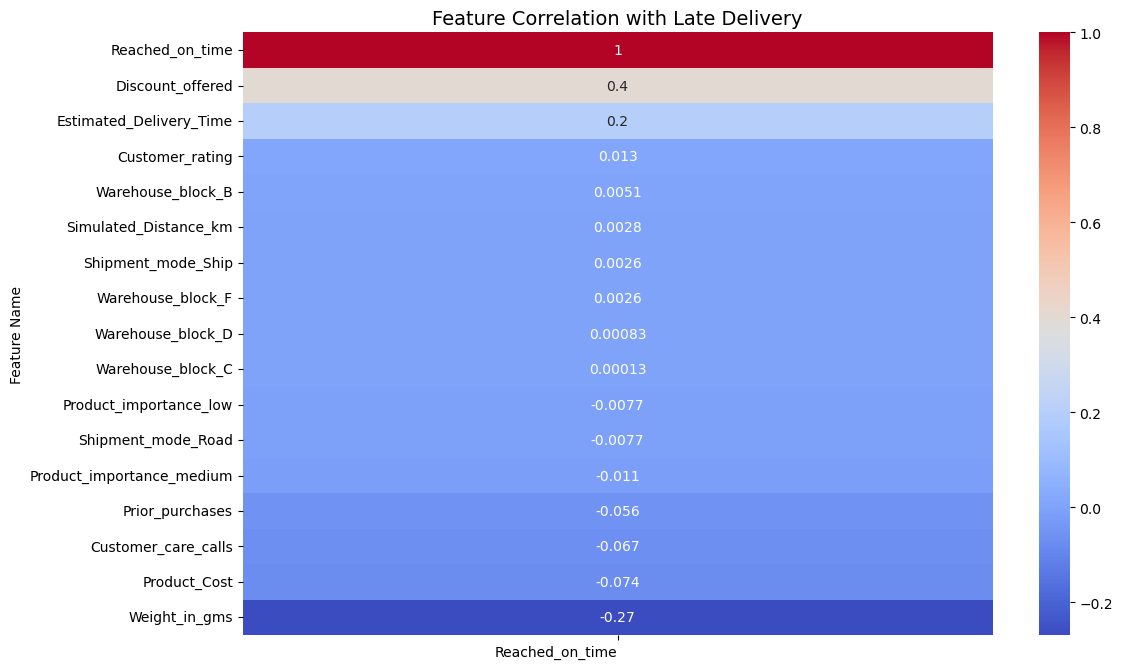

In [53]:
# Compute correlation matrix
corr = df[features + ['Reached_on_time']].corr()

# Sort features by correlation strength (optional)
sorted_features = corr['Reached_on_time'].sort_values(ascending=False).index

# Create horizontal layout
plt.figure(figsize=(12, 2 + len(features) * 0.3))
sns.heatmap(
    corr.loc[sorted_features, ['Reached_on_time']],
    annot=True,
    cmap='coolwarm',
    cbar=True
)
plt.title('Feature Correlation with Late Delivery', fontsize=14)

plt.ylabel('Feature Name')
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

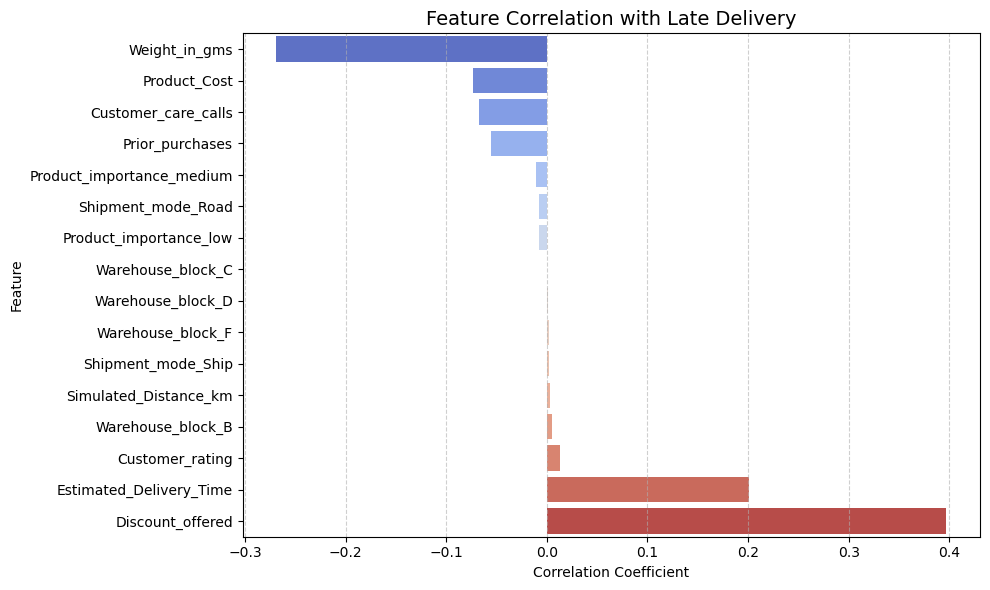

In [57]:
# Extract correlations with the target
corr_target = corr['Reached_on_time'].drop('Reached_on_time')

# Sort correlations
corr_target_sorted = corr_target.sort_values(ascending=True)

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_target_sorted.values, y=corr_target_sorted.index, palette='coolwarm')

plt.title('Feature Correlation with Late Delivery', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [55]:
#Agarrarle la onda chido al random forest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.58      0.69      0.63       895
           1       0.76      0.65      0.70      1305

    accuracy                           0.67      2200
   macro avg       0.67      0.67      0.66      2200
weighted avg       0.68      0.67      0.67      2200

ROC AUC: 0.7496556005051477


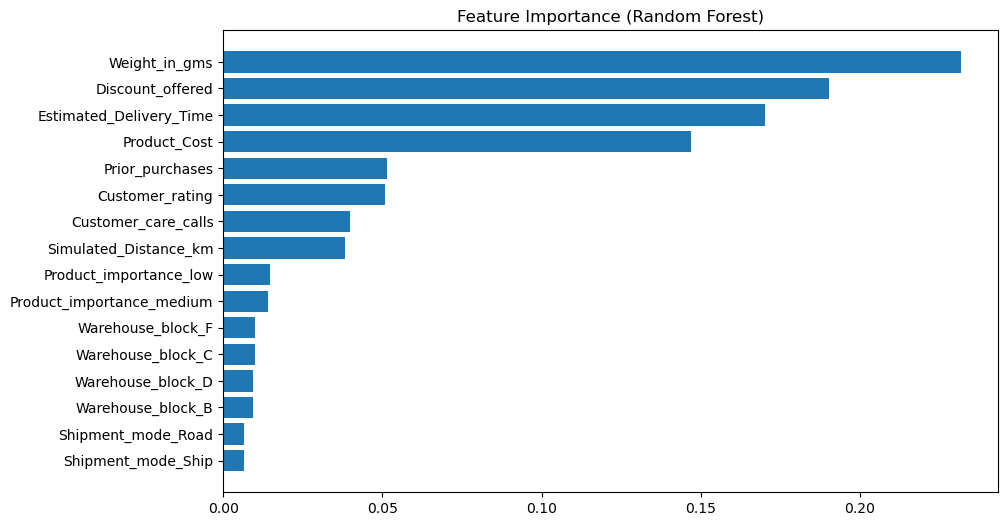

In [56]:
#FEATURE IMPORTANCE

feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance (Random Forest)")
plt.show()
